<a href="https://colab.research.google.com/github/noorfatima640/water-quality-ml/blob/main/XGBoost_and_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

file_path = "/content/sample_data/water-quality-FINAL-cleaned.csv"
df = pd.read_csv(file_path)

print(df.shape)
df.head()

# encode Season into numeric form
df = pd.get_dummies(df, columns=["Season"], drop_first=True)

print("Columns after encoding:")
df.columns

(138981, 10)
Columns after encoding:


Index(['pH', 'DO', 'Conductivity', 'Temperature', 'Total_N', 'Orthophosphate',
       'Year', 'Month', 'Season_numerical', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')

In [6]:
## Step 1: scale the parameters
from sklearn.preprocessing import MinMaxScaler
import numpy as np

wqi_cols = [
    "pH", "DO", "Conductivity",
    "Temperature", "Total_N", "Orthophosphate"
]

scaler = MinMaxScaler()
scaled_vals = scaler.fit_transform(df[wqi_cols])
scaled_df = pd.DataFrame(scaled_vals, columns=wqi_cols)

# Step 2: group parameters
positive = ["DO", "pH"]
negative = ["Temperature", "Conductivity", "Total_N", "Orthophosphate"]

# Step 3: build the WQI score
wqi = np.zeros(len(df))

for col in positive:
    wqi += scaled_df[col]

for col in negative:
    wqi += (1 - scaled_df[col])

# Step 4: convert to 0–100 index
wqi = wqi / len(wqi_cols)
df["WQI"] = wqi * 100

df["WQI"].head()

,WQI
0,71.340951
1,68.535526
2,69.910607
3,66.547837
4,71.017101


Temperature RMSE: 0.11268393829779666
Temperature R² : 0.9756896949663167


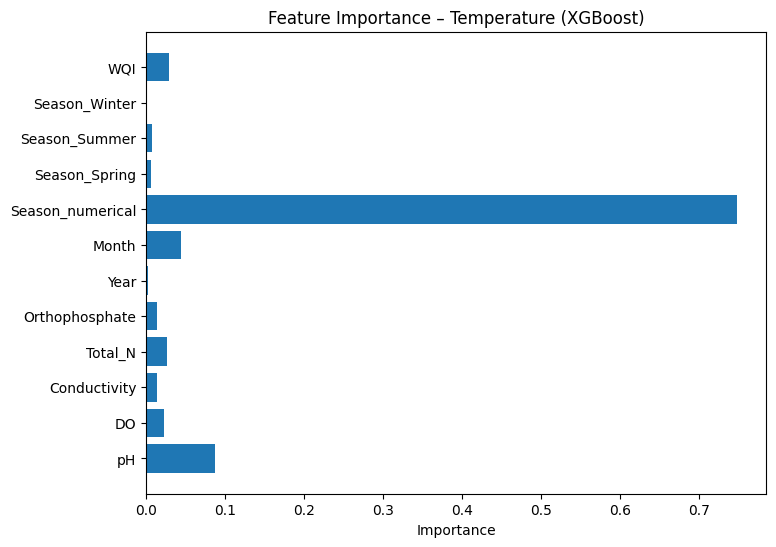

In [7]:
# Step 1: set up target and features
y_temp = df["Temperature"]
X_temp = df.drop(columns=["Temperature"])

# Step 2: train/test split
from sklearn.model_selection import train_test_split
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

# Step 3: train XGBoost model
from xgboost import XGBRegressor

model_temp = XGBRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_temp.fit(X_train_temp, y_train_temp)

# Step 4: evaluate model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_temp = model_temp.predict(X_test_temp)

rmse_temp = np.sqrt(mean_squared_error(y_test_temp, y_pred_temp))
r2_temp = r2_score(y_test_temp, y_pred_temp)

print("Temperature RMSE:", rmse_temp)
print("Temperature R² :", r2_temp)

# Step 5: feature importance plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(X_temp.columns, model_temp.feature_importances_)
plt.title("Feature Importance – Temperature (XGBoost)")
plt.xlabel("Importance")
plt.show()

WQI RMSE: 0.330743945511653
WQI R² : 0.9942926681954947


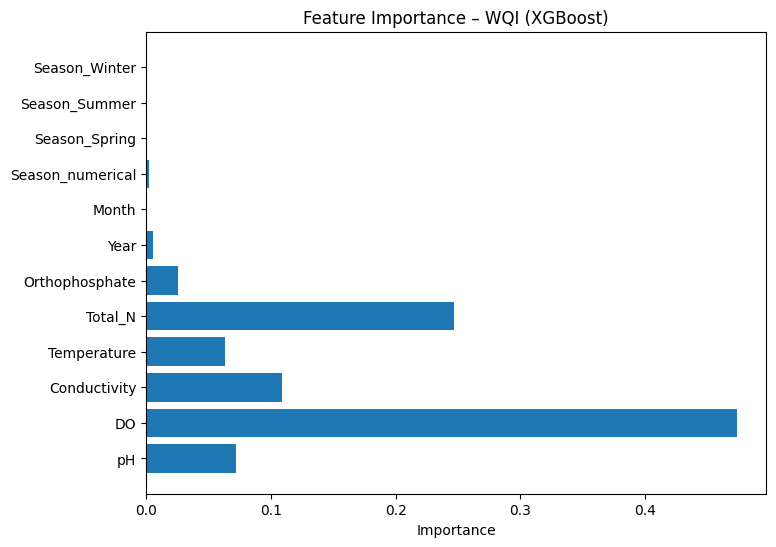

In [8]:
# Step 1: set up target and features
y_wqi = df["WQI"]
X_wqi = df.drop(columns=["WQI"])

# Step 2: train/test split
from sklearn.model_selection import train_test_split
X_train_wqi, X_test_wqi, y_train_wqi, y_test_wqi = train_test_split(
    X_wqi, y_wqi, test_size=0.2, random_state=42
)

# Step 3: train XGBoost model
from xgboost import XGBRegressor

model_wqi = XGBRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_wqi.fit(X_train_wqi, y_train_wqi)

# Step 4: evaluate model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_wqi = model_wqi.predict(X_test_wqi)

rmse_wqi = np.sqrt(mean_squared_error(y_test_wqi, y_pred_wqi))
r2_wqi = r2_score(y_test_wqi, y_pred_wqi)

print("WQI RMSE:", rmse_wqi)
print("WQI R² :", r2_wqi)

# Step 5: feature importance plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(X_wqi.columns, model_wqi.feature_importances_)
plt.title("Feature Importance – WQI (XGBoost)")
plt.xlabel("Importance")
plt.show()

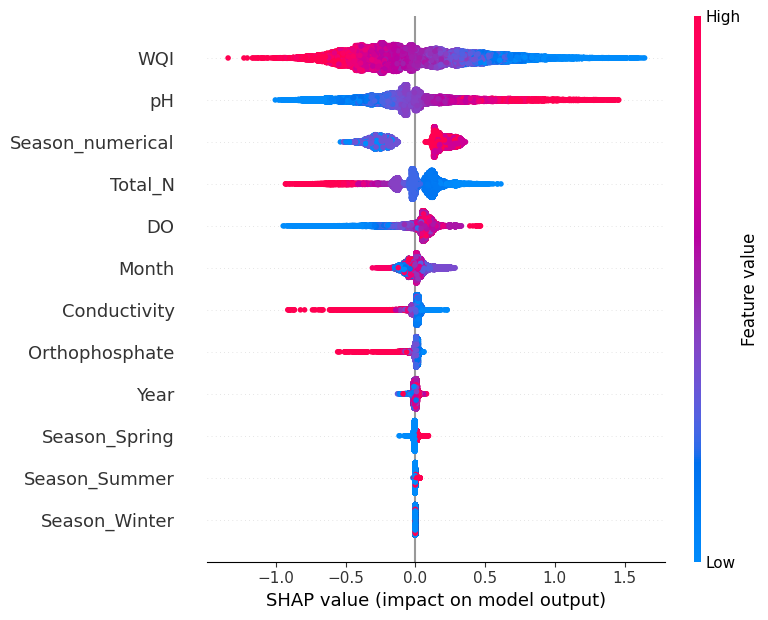

In [9]:
# Step 1: install SHAP
!pip install shap

# Step 2: convert test set to float (SHAP needs numeric values)
X_test_temp = X_test_temp.astype(float)

# Step 3: build SHAP explainer
import shap
explainer_temp = shap.TreeExplainer(model_temp)

# Step 4: calculate SHAP values
shap_values_temp = explainer_temp.shap_values(X_test_temp)

# Step 5: summary plot
shap.summary_plot(shap_values_temp, X_test_temp)

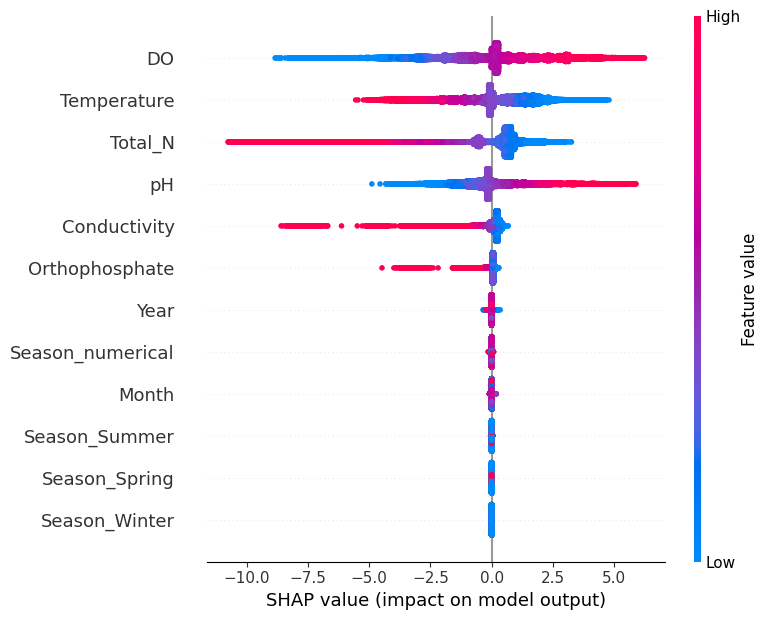

In [10]:
# Step 1: convert test set to float
X_test_wqi = X_test_wqi.astype(float)

# Step 2: build SHAP explainer
explainer_wqi = shap.TreeExplainer(model_wqi)

# Step 3: calculate SHAP values
shap_values_wqi = explainer_wqi.shap_values(X_test_wqi)

# Step 4: summary plot
shap.summary_plot(shap_values_wqi, X_test_wqi)